## Testing Mamba on VM

### Mamba Model

In [1]:
import os
import pickle
import gc
import numpy as np
import pandas as pd
import torch
from torch import nn
from mamba_ssm.modules.mamba_simple import Mamba  # your Mamba
from pytorch_forecasting import TimeSeriesDataSet  # 🔧 FIX 1 – correct import
from pytorch_forecasting.models.temporal_fusion_transformer import (
    TemporalFusionTransformer,
)
from pytorch_forecasting.metrics import QuantileLoss

# from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data import GroupNormalizer
from torch.utils.data import DataLoader
from pytorch_forecasting.utils import move_to_device  # ✔ recursive

# Correction here
import lightning.pytorch as pl
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
)  # ✅ Correction ici

/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
import torch
from torch import nn
from typing import Tuple, Dict


# ---------------------------------------------------------------------
# utils
# ---------------------------------------------------------------------
def _last_step_summary(
    seq: torch.Tensor, lengths: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Retourne (h, c) en prenant le dernier pas *réel* pour chaque séquence.
    seq: (B, L, D)
    lengths: (B,) longueurs totales (encoder+decoder) pour chaque élément du batch.
    """
    idx = lengths.to(seq.device) - 1  # (B,)
    h = seq[torch.arange(seq.size(0), device=seq.device), idx]  # (B, D)
    h = h.unsqueeze(0)  # (1, B, D) pour coller à l'API TFT
    return h, h.clone()


# ---------------------------------------------------------------------
# Mamba blocks
# ---------------------------------------------------------------------
class ResidualMambaBlock(nn.Module):
    """Norm -> Mamba -> Dropout -> Residual."""

    def __init__(self, d_model: int, dropout: float = 0.1, checkpoint: bool = False):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.mamba = Mamba(d_model=d_model)
        self.drop = nn.Dropout(dropout)
        self.checkpoint = checkpoint

    def _forward_inner(self, x: torch.Tensor) -> torch.Tensor:
        y = self.mamba(self.norm(x))  # (B, L, D)
        return x + self.drop(y)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.checkpoint and self.training:
            return torch.utils.checkpoint.checkpoint(
                self._forward_inner, x, use_reentrant=False
            )
        return self._forward_inner(x)


class StackedMamba(nn.Module):
    """Empile plusieurs blocs Mamba résiduels."""

    def __init__(
        self,
        d_model: int,
        depth: int = 4,
        dropout: float = 0.1,
        checkpoint: bool = False,
    ):
        super().__init__()
        self.blocks = nn.ModuleList(
            [ResidualMambaBlock(d_model, dropout, checkpoint) for _ in range(depth)]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for blk in self.blocks:
            x = blk(x)
        return x


class DummyMambaAttn(nn.Module):
    """Remplace la MultiHeadAttention TFT par un petit mixeur Mamba sur q seulement.
    Renvoie des poids d'attention nuls pour préserver l'API & l'interprétabilité.
    """

    def __init__(
        self, d_model: int, n_head: int = 1, depth: int = 1, dropout: float = 0.0
    ):
        super().__init__()
        self.n_head = n_head
        self.mixer = StackedMamba(d_model=d_model, depth=depth, dropout=dropout)

    def forward(self, q, k=None, v=None, mask=None):
        out = self.mixer(q)  # (B, L_q, D)
        B, L_q, _ = q.shape
        L_k = k.size(1) if k is not None else L_q
        attn = q.new_zeros(B, self.n_head, L_q, L_k)  # dummy weights
        # (Optionnel) appliquer mask => attn.masked_fill_(mask, 0.) si tu veux quelque chose de cohérent
        return out, attn


# ---------------------------------------------------------------------
# MambaTFT
# ---------------------------------------------------------------------
class MambaTFT(TemporalFusionTransformer):
    """Temporal Fusion Transformer où LSTM & MHA sont remplacés par des blocs Mamba."""

    def __init__(
        self,
        *args,
        mamba_depth: int = 4,
        mamba_dropout: float = 0.1,
        mamba_checkpoint: bool = False,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        # kill off the old LSTM/MHA so they don't hang around as dead params
        del self.lstm_encoder   # you’re replacing it anyway
        del self.lstm_decoder
        del self.multihead_attn
        del self.static_context_initial_cell_lstm
        del self.static_context_initial_hidden_lstm

        d_model = self.hparams.hidden_size

        # 1) Empilement Mamba sur toute la fenêtre (encoder+decoder)
        self.lstm_encoder = StackedMamba(
            d_model=d_model,
            depth=mamba_depth,
            dropout=mamba_dropout,
            checkpoint=mamba_checkpoint,
        )
        self.lstm_decoder = nn.Identity()  # conservé pour compatibilité API

        # 2) Faux MHA -> Mamba léger
        self.multihead_attn = DummyMambaAttn(
            d_model=d_model,
            n_head=self.hparams.attention_head_size,
            depth=1,
            dropout=mamba_dropout,
        )

    # ------------------------------------------------------------------
    # On ne touche qu'à la partie LSTM/attention, le reste reste identique.
    # ------------------------------------------------------------------
    def forward(self, x: Dict[str, torch.Tensor]):
        encoder_lengths = x["encoder_lengths"]
        decoder_lengths = x["decoder_lengths"]
        total_lengths = encoder_lengths + decoder_lengths

        x_cat = torch.cat([x["encoder_cat"], x["decoder_cat"]], dim=1)
        x_cont = torch.cat([x["encoder_cont"], x["decoder_cont"]], dim=1)
        timesteps = x_cont.size(1)  # L_enc + L_dec
        max_encoder_length = int(encoder_lengths.max())

        # ==== 1) Embedding & variable selection (unchanged) =============
        input_vectors = self.input_embeddings(x_cat)
        input_vectors.update(
            {
                name: x_cont[..., idx].unsqueeze(-1)
                for idx, name in enumerate(self.hparams.x_reals)
                if name in self.reals
            }
        )
        if len(self.static_variables) > 0:
            static_embedding_src = {
                name: input_vectors[name][:, 0] for name in self.static_variables
            }
            static_embedding, static_variable_selection = (
                self.static_variable_selection(static_embedding_src)
            )
        else:
            static_embedding = torch.zeros(
                (x_cont.size(0), self.hparams.hidden_size),
                dtype=self.dtype,
                device=self.device,
            )
            static_variable_selection = torch.zeros(
                (x_cont.size(0), 0), dtype=self.dtype, device=self.device
            )
        static_context_varsel = self.expand_static_context(
            self.static_context_variable_selection(static_embedding), timesteps
        )
        embeddings_varying_encoder = {
            n: input_vectors[n][:, :max_encoder_length] for n in self.encoder_variables
        }
        embeddings_varying_encoder, encoder_sparse_weights = (
            self.encoder_variable_selection(
                embeddings_varying_encoder,
                static_context_varsel[:, :max_encoder_length],
            )
        )
        embeddings_varying_decoder = {
            n: input_vectors[n][:, max_encoder_length:] for n in self.decoder_variables
        }
        embeddings_varying_decoder, decoder_sparse_weights = (
            self.decoder_variable_selection(
                embeddings_varying_decoder,
                static_context_varsel[:, max_encoder_length:],
            )
        )

        # ==== 2) Mamba sur toute la fenêtre =============================
        embeddings_full = torch.cat(
            [embeddings_varying_encoder, embeddings_varying_decoder], dim=1
        )  # (B, L, D)
        full_seq = self.lstm_encoder(embeddings_full)  # (B, L, D)

        encoder_output = full_seq[:, :max_encoder_length]
        decoder_output = full_seq[:, max_encoder_length:]
        #h, c = _last_step_summary(full_seq, total_lengths)

        # ==== 3) Skip connection & gating (inchangé) ====================
        lstm_output_encoder = self.post_lstm_gate_encoder(encoder_output)
        lstm_output_encoder = self.post_lstm_add_norm_encoder(
            lstm_output_encoder, embeddings_varying_encoder
        )
        lstm_output_decoder = self.post_lstm_gate_decoder(decoder_output)
        lstm_output_decoder = self.post_lstm_add_norm_decoder(
            lstm_output_decoder, embeddings_varying_decoder
        )
        lstm_output = torch.cat([lstm_output_encoder, lstm_output_decoder], dim=1)

        # ==== 4) Static enrichment & pseudo-attention ===================
        static_context_enrich = self.static_context_enrichment(static_embedding)
        attn_input = self.static_enrichment(
            lstm_output, self.expand_static_context(static_context_enrich, timesteps)
        )

        attn_output, attn_output_weights = self.multihead_attn(
            q=attn_input[:, max_encoder_length:],
            k=attn_input,
            v=attn_input,
            mask=self.get_attention_mask(
                encoder_lengths=encoder_lengths, decoder_lengths=decoder_lengths
            ),
        )
        attn_output = self.post_attn_gate_norm(
            attn_output, attn_input[:, max_encoder_length:]
        )

        # ==== 5) Position‑wise FF & output head ========================
        output = self.pos_wise_ff(attn_output)
        output = self.pre_output_gate_norm(output, lstm_output[:, max_encoder_length:])
        if self.n_targets > 1:
            output = [layer(output) for layer in self.output_layer]
        else:
            output = self.output_layer(output)

        return self.to_network_output(
            prediction=self.transform_output(output, target_scale=x["target_scale"]),
            encoder_attention=attn_output_weights[..., :max_encoder_length],
            decoder_attention=attn_output_weights[..., max_encoder_length:],
            static_variables=static_variable_selection,
            encoder_variables=encoder_sparse_weights,
            decoder_variables=decoder_sparse_weights,
            decoder_lengths=decoder_lengths,
            encoder_lengths=encoder_lengths,
        )

### Download Dataset

In [3]:
# Load CGM data from Google Cloud Storage into a Pandas DataFrame
from google.cloud import storage
import pandas as pd
from io import BytesIO

client = storage.Client()
bucket = client.bucket('cgmproject2025')
blob   = bucket.blob('ai-ready/data/train_timeseries_dmd.feather')

data_bytes = blob.download_as_bytes()          # get raw bytes
train = pd.read_feather(BytesIO(data_bytes))

In [4]:
train.head()  # Display the first few rows of the DataFrame

,participant_id,ts,cgm_glucose,activity_steps,calories_value,heartrate,oxygen_saturation,respiration_rate,sleep_stage,stress_level,...,cgm_diff_lag_3,cgm_diff_lag_6,cgm_lagdiff_1_3,cgm_lagdiff_3_6,minute_of_day,tod_sin,tod_cos,cgm_rolling_mean,cgm_rolling_std,max_eigenvalues
14,1023,2023-08-30 19:00:00+00:00,95.0,102.0,4.0,83.60,93.0,2.640,light,6.6,...,-6.0,-7.0,-8.0,-1.0,70,0.300706,0.953717,107.416667,14.164349,0.964150
15,1023,2023-08-30 19:05:00+00:00,101.0,102.0,4.0,90.40,93.0,-1.000,light,-2.0,...,7.0,-4.0,1.0,-11.0,75,0.321439,0.946930,104.500000,10.991732,0.971599
16,1023,2023-08-30 19:10:00+00:00,107.0,51.0,35.0,90.60,93.0,-1.000,light,-2.0,...,14.0,5.0,8.0,-9.0,80,0.342020,0.939693,102.666667,7.946793,0.983498
17,1023,2023-08-30 19:15:00+00:00,108.0,0.0,35.0,82.40,93.0,18.808,light,57.8,...,13.0,7.0,12.0,-6.0,85,0.362438,0.932008,101.583333,5.822501,0.988338
18,1023,2023-08-30 19:20:00+00:00,104.0,0.0,35.0,82.75,93.0,15.624,light,38.2,...,3.0,10.0,7.0,7.0,90,0.382683,0.923880,100.916667,4.907477,0.990611


In [5]:
import os
import torch

rank = os.environ.get("LOCAL_RANK", "NotSet")
gpu_count = torch.cuda.device_count()
print(f"[INFO] RANK={rank} | CUDA devices={gpu_count}")

[INFO] RANK=NotSet | CUDA devices=1


In [6]:
import psutil
import datetime


def log_memory(message=""):
    pid = os.getpid()
    process = psutil.Process(pid)
    mem_cpu = process.memory_info().rss / 1e9  # en Go

    if torch.cuda.is_available():
        mem_gpu_allocated = torch.cuda.memory_allocated() / 1e9
        mem_gpu_reserved = torch.cuda.memory_reserved() / 1e9
    else:
        mem_gpu_allocated = mem_gpu_reserved = 0.0

    print(f"[{datetime.datetime.now()}] {message}")
    print(f"🧠 CPU Mem utilisée: {mem_cpu:.2f} GB")
    print(
        f"🎮 GPU Mem allouée: {mem_gpu_allocated:.2f} GB | réservée: {mem_gpu_reserved:.2f} GB"
    )

In [7]:
def create_tft_dataloaders(train_df, horizon=12, context_length=72, batchsize=32):
    log_memory("🚀 Start of Dataloader Creation")

    # --- Extra Variables Outside Main Timeseries ---
    static_categoricals = [
        "participant_id",
        "clinical_site",
        "study_group",
    ]  # Have info on participant
    static_reals = ["age"]

    time_varying_known_categoricals = ["sleep_stage"]
    time_varying_known_reals = [
        "ds",
        "minute_of_day",
        "tod_sin",
        "tod_cos",
        "activity_steps",
        "calories_value",
        "heartrate",
        "oxygen_saturation",
        "respiration_rate",
        "stress_level",
        "max_eigenvalues",
    ]  # To ensure time index (ordering is met)
    time_varying_unknown_reals = [
        "cgm_glucose",
        "cgm_lag_1",
        "cgm_lag_3",
        "cgm_lag_6",
        "cgm_diff_lag_1",
        "cgm_diff_lag_3",
        "cgm_diff_lag_6",
        "cgm_lagdiff_1_3",
        "cgm_lagdiff_3_6",
        "cgm_rolling_mean",
        "cgm_rolling_std",
    ]

    # --- Découpe temporelle ---
    # max_date = train_df["ds"].max()
    # cut_off_date = max_date - pd.Timedelta(days=context_length)

    # horizon = 12  # Predict 12 steps (1 hour)
    cut_off_date = train_df["ds"].max() - horizon  # Use latest horizon

    # --- Création du TimeSeriesDataSet ---
    training = TimeSeriesDataSet(
        train_df[train_df["ds"] < cut_off_date],
        time_idx="ds",
        target="cgm_glucose",
        group_ids=["participant_id"],
        max_encoder_length=context_length,
        max_prediction_length=horizon,
        static_categoricals=static_categoricals,
        static_reals=static_reals,
        time_varying_known_categoricals=time_varying_known_categoricals,
        time_varying_known_reals=time_varying_known_reals,
        time_varying_unknown_reals=time_varying_unknown_reals,
        target_normalizer=GroupNormalizer(groups=["participant_id"]),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

    validation = training.from_dataset(
        training, train_df, predict=True, stop_randomization=True
    )

    # --- Dataloaders ---
    train_dataloader = training.to_dataloader(
        train=True,
        batch_size=batchsize,
        persistent_workers=False,
        num_workers=1,
        pin_memory=False, # CHANGE TO REDUCE MOMORY USAGE
    )
    val_dataloader = validation.to_dataloader(
        train=False,
        batch_size=batchsize,
        num_workers=0,
        persistent_workers=False,
        pin_memory=False,
    )

    return training, val_dataloader, train_dataloader, validation

In [10]:
from lightning.pytorch.strategies import DDPStrategy


def TFT_train(train_df):
    # --- Paramètres du modèle ---

    log_memory("🚀 Début du chargement des dataloaders")
    # horizon = 12
    # context_length = 72 #6 HOURS
    # batchsize = 32
    horizon = 12
    context_length = 288 # 1 DAY
    batchsize = 32

    training, val_dataloader, train_dataloader, validation = create_tft_dataloaders(
        train_df, horizon=horizon, context_length=context_length, batchsize=batchsize
    )

    del train_df
    gc.collect()

    log_memory("First creation of dataloaders")

    # --- Définir la perte avec les quantiles souhaités ---
    loss = QuantileLoss(quantiles=[0.2, 0.5, 0.8])  # 20%, 50% (median), 80% quantiles
    # 95% confidence intervals (Choice!) - Not a good one - underperformant/underconfident predictions.

    # --- Définition du TFT ---
    tft = MambaTFT.from_dataset(
        training,
        learning_rate=0.003,
        hidden_size=64,
        attention_head_size=2,
        dropout=0.2,
        loss=loss,
        log_interval=10,
        log_val_interval=1,
        reduce_on_plateau_patience=4,  # If validation loss does not improve for 8 epochs, reduce learning rate
    )

    log_memory("Model Creations before training")

    # --- Entraînement ---
    trainer = Trainer(
        max_epochs=1,  # 30 is good, but 10 for testing
        gradient_clip_val=0.1,
        limit_train_batches=100, #13000,  # For testing purposes, limit to 2 batches
        val_check_interval=0.2,  # How many times want to check validation per epoch (checking for every epoch is put 1.0). Lower = more frequent checking.
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=10, mode="min"),
            LearningRateMonitor(logging_interval="epoch"),
        ],
        enable_progress_bar=True,
        accelerator="gpu",  # GPU usage
        devices=1,
        strategy= "auto", #"ddp_notebook",
        # strategy=DDPStrategy(
        #     find_unused_parameters=True, # report any dead params
        #     start_method="fork"          # <-- fork works in notebooks
        # ) , 
        #plugins=DDPPlugin(find_unused_parameters=True),
        #"ddp_notebook", #"ddp_notebook_find_unused_parameters_true", #"ddp_notebook", #"ddp_notebook_find_unused_parameters_true",  # "ddp_notebook",  #ddp # DistributedDataParallel
        #strategy=DDPStrategy(find_unused_parameters=True),
        # precision="16-mixed",  # Add this lin e for mixed precision training
    )
    log_memory("Before training")

    trainer.fit(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

    log_memory("End training")

    return tft, trainer, val_dataloader, train_dataloader, validation, training

#### Make sure the strategy = 'auto'

In [11]:
tft, trainer, val_dataloader, train_dataloader, validation, training = TFT_train(train)

[2025-07-31 01:01:16.581932] 🚀 Début du chargement des dataloaders
🧠 CPU Mem utilisée: 7.14 GB
🎮 GPU Mem allouée: 0.00 GB | réservée: 0.07 GB
[2025-07-31 01:01:16.583242] 🚀 Start of Dataloader Creation
🧠 CPU Mem utilisée: 7.14 GB
🎮 GPU Mem allouée: 0.00 GB | réservée: 0.07 GB
[2025-07-31 01:01:36.427777] First creation of dataloaders
🧠 CPU Mem utilisée: 8.60 GB
🎮 GPU Mem allouée: 0.00 GB | réservée: 0.07 GB


/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                       

[2025-07-31 01:01:36.723629] Model Creations before training
🧠 CPU Mem utilisée: 8.60 GB
🎮 GPU Mem allouée: 0.00 GB | réservée: 0.07 GB
[2025-07-31 01:01:36.734693] Before training
🧠 CPU Mem utilisée: 8.60 GB
🎮 GPU Mem allouée: 0.00 GB | réservée: 0.07 GB
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 100/100 [00:42<00:00,  2.37it/s, v_num=4, train_loss_step=10.30, val_loss=10.80, train_loss_epoch=14.10]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 100/100 [00:42<00:00,  2.36it/s, v_num=4, train_loss_step=10.30, val_loss=10.80, train_loss_epoch=14.10]
[2025-07-31 01:02:20.424331] End training
🧠 CPU Mem utilisée: 8.61 GB
🎮 GPU Mem allouée: 0.01 GB | réservée: 0.07 GB


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x375 with 1 Axes>,
 'encoder_variables': <Figure size 700x800 with 1 Axes>,
 'decoder_variables': <Figure size 700x525 with 1 Axes>}

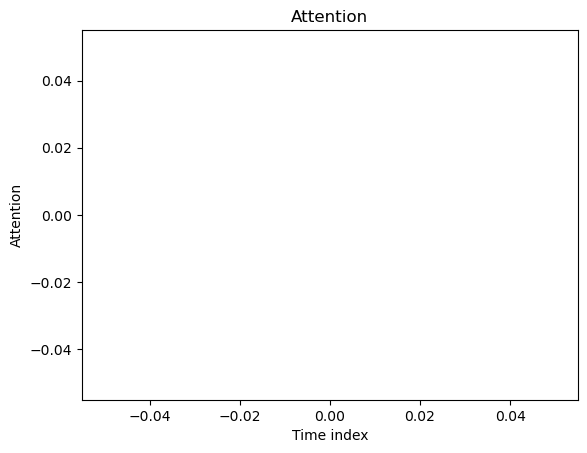

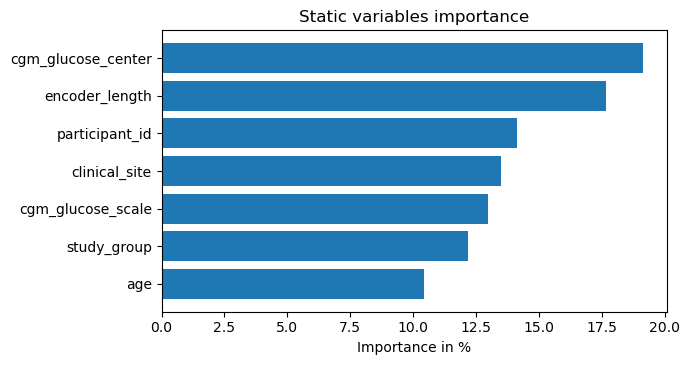

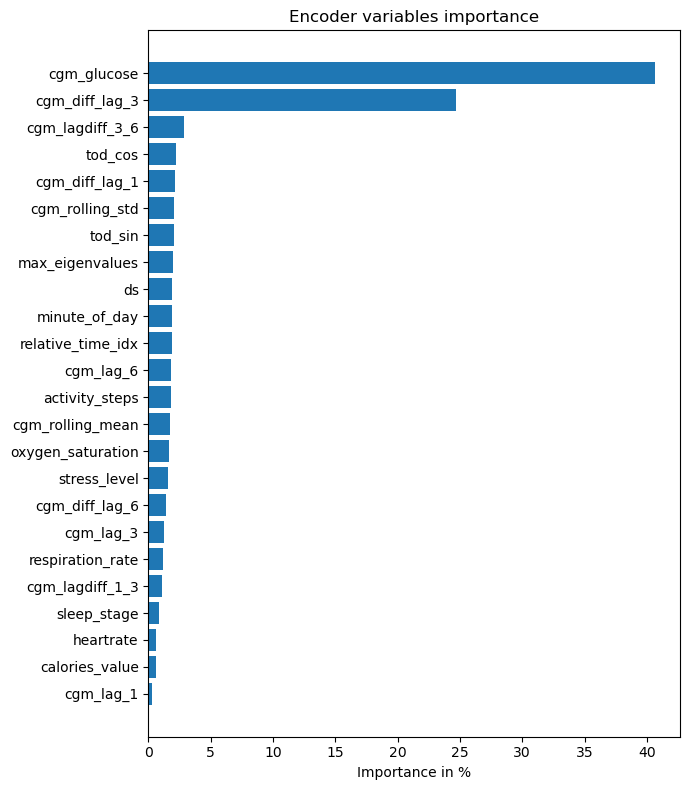

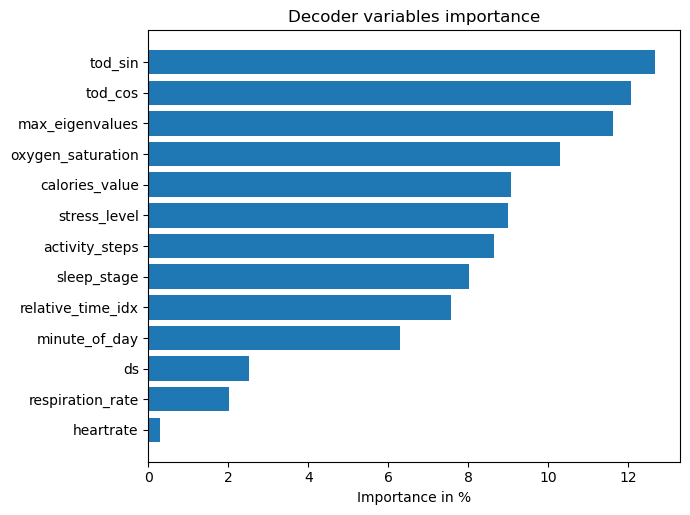

In [12]:
# --- Prédiction ---
# Assure-toi que val_dataloader est bien structuré
y_hat_raw = tft.predict(val_dataloader, mode="raw")
# --- Visualisation des interprétations ---
interpretation = tft.interpret_output(y_hat_raw, reduction="sum")
tft.plot_interpretation(interpretation)